In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import scanpy as sc
from anndata import read_h5ad

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

from sklearn.manifold import TSNE
import umap
from sklearn import manifold
from sklearn.metrics import silhouette_score

2025-05-23 14:58:02.573715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Step 1: Only use normal and type 2 data

In [2]:
# Load the data
adata = sc.read_h5ad("filtered_normal_vs_type2_5percent.h5ad")


## Step 2: How is the data structured?


In [3]:
print("Filtered data:")
print("Number of cells:", adata.n_obs)
print("Number of genes:", adata.n_vars)

print(adata.obs['disease'].value_counts())

Filtered data:
Number of cells: 11717
Number of genes: 31202
normal                      6730
type 2 diabetes mellitus    4987
Name: disease, dtype: int64


If a gene is always expressed at the same level in all cells → variance is 0

If a gene is expressed in some cells but not others, or at very different levels → variance is high

So genes with largest variance must be the most important ones.

In [4]:
#sc.pp.highly_variable_genes(adata, n_top_genes=100, flavor='cell_ranger')
#adatafilt = adata[:, adata.var['highly_variable']].copy()

# Convert sparse matrix to dense temporarily (can also do in batches for big data)
X_dense = adata.X.toarray()

# Calculate variance across cells for each gene (axis=0)
gene_variances = np.var(X_dense, axis=0)

# Get indices of top N variable genes (e.g. 100)
top_gene_indices = np.argsort(gene_variances)[-100:]

# Subset AnnData object to just those genes
adatafilt = adata[:, top_gene_indices].copy()

In [5]:
X = adatafilt.X.toarray() if not isinstance(adatafilt.X, np.ndarray) else adatafilt.X
gene_variances = np.var(X, axis=0)


# Create a DataFrame with gene names and their variances
var_df = pd.DataFrame({
    'gene': adatafilt.var_names,
    'variance': gene_variances
})

feature_names = list(adatafilt.var_names)


## Cluster

/Users/majalindholm/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


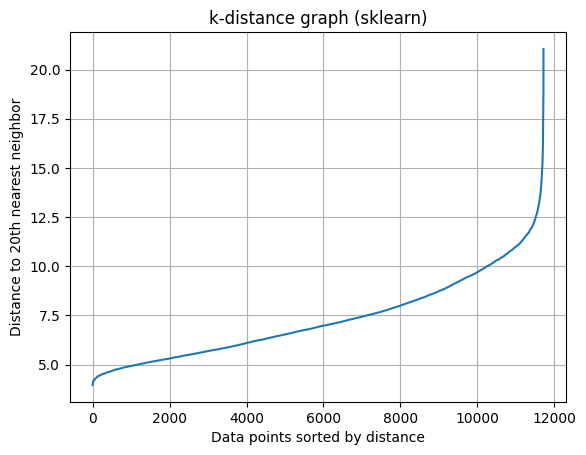

In [6]:
from sklearn.neighbors import NearestNeighbors

k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(X)
distances, indices = nbrs.kneighbors(X)

k_distances = np.sort(distances[:, k])  # take k-th neighbor (not 0th)
plt.plot(k_distances)
plt.xlabel("Data points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title("k-distance graph (sklearn)")
plt.grid(True)
plt.show()


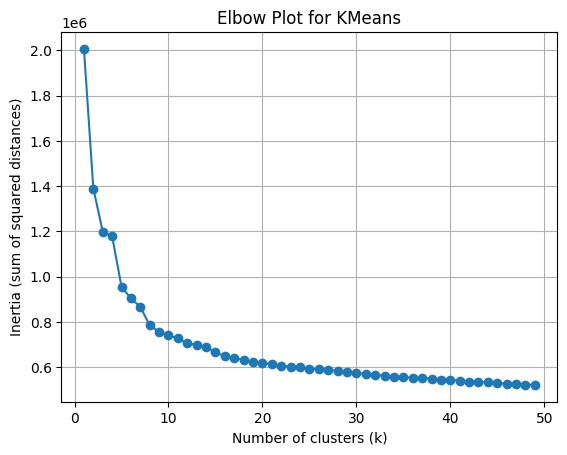

In [7]:
from sklearn.cluster import KMeans

inertias = []
k_range = range(1, 50)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

slopes = np.diff(inertias)  # This gives inertia[k] - inertia[k+1]

# Plotting the elbow curve
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (sum of squared distances)')
plt.title('Elbow Plot for KMeans')
plt.grid(True)
plt.show()



/Users/majalindholm/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/majalindholm/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


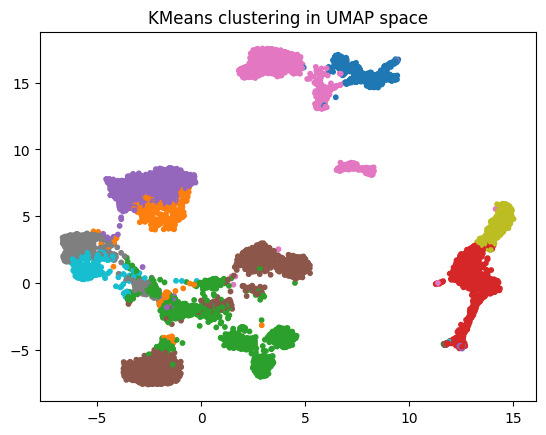

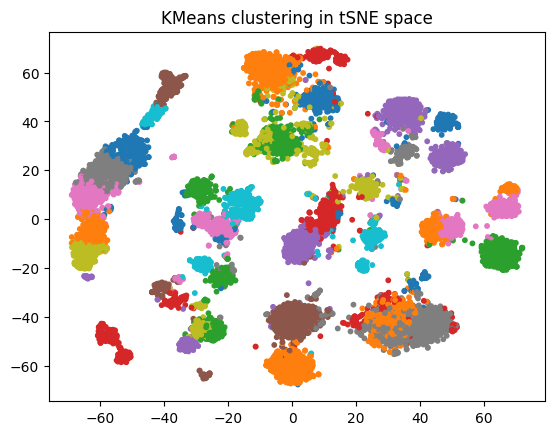

Silhouette score (UMAP): 0.1660857
Silhouette score (tSNE): 0.094264716


In [14]:
# Transforming to 2D using t-SNE and UMAP
X_tSNE = manifold.TSNE(n_components=2).fit_transform(X)
X_UMAP = umap.UMAP(n_neighbors=100, min_dist=0.4, random_state=42).fit_transform(X)

labels_u = KMeans(n_clusters=10).fit_predict(X)
labels_t = KMeans(n_clusters=50).fit_predict(X)

plt.scatter(X_UMAP[:, 0], X_UMAP[:, 1], c=labels_u, cmap='tab10', s=10)
plt.title("KMeans clustering in UMAP space")
plt.show()

plt.scatter(X_tSNE[:, 0], X_tSNE[:, 1], c=labels_t, cmap='tab10', s=10)
plt.title("KMeans clustering in tSNE space")
plt.show()

print("Silhouette score (UMAP):", silhouette_score(X, labels_u))
print("Silhouette score (tSNE):", silhouette_score(X, labels_t))